# Data Processing, Wrangling and EDA

---
### Required Libs

In [79]:
# Libraries installed/Downloaded from Web for running below code
#pip install Talib
#conda install -c conda-forge ta-lib
#Conda install Boruta
#conda install -c plotly python-kaleido

In [5]:
import os
import numpy as np
import pandas as pd
import plotly.express as px
import io
import talib
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.display import Image
from talib.abstract import *
import shutil
from wordcloud import WordCloud, STOPWORDS
from boruta import BorutaPy
from collections import defaultdict

In [6]:
# Creating path to save Plotly image files:
if os.path.exists("images"):
    shutil.rmtree("images")
os.mkdir("images")

figindex = 0 # figure dynamic index

# Function to display images:
def figshow(figindex, fig):
    fig.write_image(f"images/fig{figindex}.png")
    return Image(f"images/fig{figindex}.png")

In [7]:
# Yang & Zhang volatility 
def get_hvol_yz(data, lookback=10):
    o = data.Open
    h = data.High
    l = data.Low
    c = data.Close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result * 100

#Defining class weights (to deal with class imbalance):
def cwts(data):
    c0, c1 = np.bincount(data['target'])
    #making the weights inversely proportional to the amount of observations:
    w0, w1 = (1/c0)*(len(data))/2, (1/c1)*(len(data))/2
    return {0: w0, 1:w1}

---
## Datasets used

* [Reddit Sentiment (run this notebook to get csv - _it takes quite a long time_)](sentiments.ipynb)

* [Bitcoin data](https://www.kaggle.com/datasets/varpit94/ethereum-data?resource=download)


---
### Data Processing

In [8]:
btc = pd.read_csv("datasets\BTC-USD.csv")

In [9]:
btc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2747 entries, 0 to 2746
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2747 non-null   object 
 1   Open       2747 non-null   float64
 2   High       2747 non-null   float64
 3   Low        2747 non-null   float64
 4   Close      2747 non-null   float64
 5   Adj Close  2747 non-null   float64
 6   Volume     2747 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 150.4+ KB


In [10]:
# Checking NaNs
btc.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
print(f'The BTC USD OHLC DB starts at {btc.Date.min()} and ends at {btc.Date.max()}.')

The BTC USD OHLC DB starts at 2014-09-17 and ends at 2022-03-25.


Importing reddit sentiment analysis Dataset:

In [12]:
reddit= pd.read_csv('reddit.csv', index_col=0)
reddit.head()

,subreddit,score,Created Date,Comment,Sentiment,score_norm,Sentiment_weighted,Day
0,business,1.0,2009-05-08 13:54:29,"Interesting, it uses IRC as a high level proto...",0.4019,0.053031,0.021313,2009-05-08
2,business,2.0,2009-05-08 14:29:56,No - the richest person will be the one with t...,0.5267,0.053064,0.027949,2009-05-08
4,business,-3.0,2009-05-08 16:35:36,&gt;a public list of all the previous transact...,-0.0772,0.052901,-0.004084,2009-05-08
6,business,2.0,2009-05-08 19:35:24,"No, that's not how bitcoin works, check out th...",-0.2960,0.053064,-0.015707,2009-05-08
8,business,0.0,2009-07-18 21:38:06,It's weird how Ron Paul gets money so incredib...,0.4968,0.052999,0.026330,2009-07-18


In [13]:
reddit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4147875 entries, 0 to 840438
Data columns (total 8 columns):
 #   Column              Dtype  
---  ------              -----  
 0   subreddit           object 
 1   score               float64
 2   Created Date        object 
 3   Comment             object 
 4   Sentiment           float64
 5   score_norm          float64
 6   Sentiment_weighted  float64
 7   Day                 object 
dtypes: float64(4), object(4)
memory usage: 284.8+ MB


---
### Bitcoin over time

In [14]:
##pip install -U kaleido

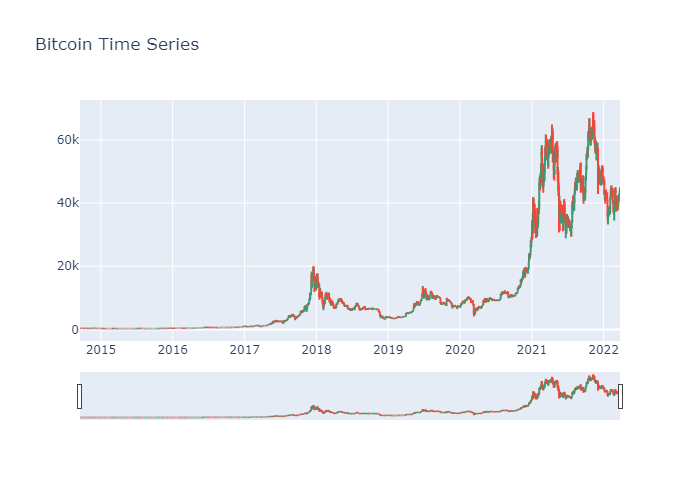

In [15]:
# Plotting OHLC over time

fig = go.Figure(data=go.Ohlc(x=btc['Date'],
                    open=btc['Open'],
                    high=btc['High'],
                    low=btc['Low'],
                    close=btc['Close']))

fig.update_layout(title="Bitcoin Time Series")
figindex += 1
figshow(figindex,fig)

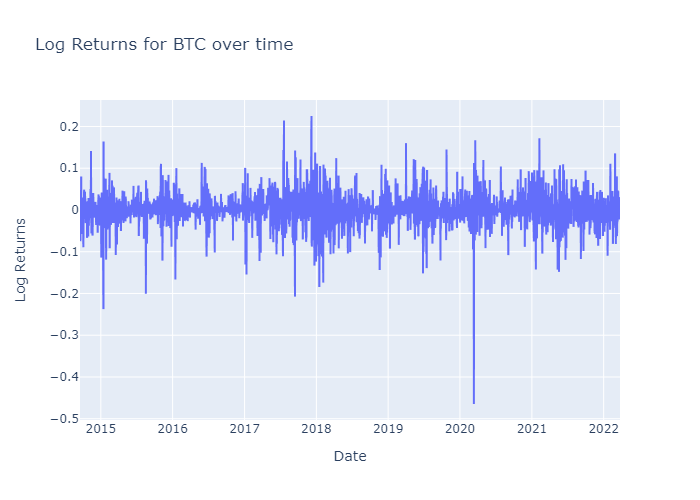

In [16]:
# Checking Returns:
btc['Pct_chg'] = btc['Close']/btc['Close'].shift(1)-1
btc['Log_Return'] = np.log(btc['Close']) - np.log(btc['Close'].shift(1))


fig = px.line(x = btc['Date'],y = btc['Log_Return'], title = "Log Returns for BTC over time")
fig.update_layout(yaxis_title="Log Returns",xaxis_title="Date")
figindex += 1
figshow(figindex,fig)

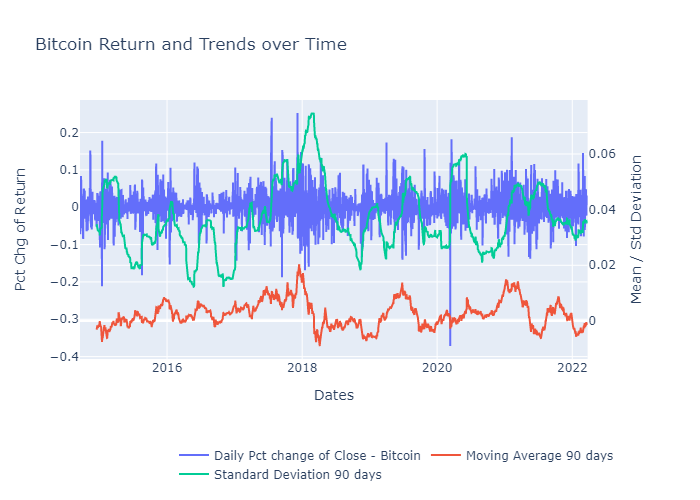

In [17]:
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(
    go.Scatter(x = btc.Date,y = btc['Pct_chg'], name="Daily Pct change of Close - Bitcoin"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x = btc.Date, y = btc['Pct_chg'].rolling(90).mean(), name = "Moving Average 90 days"),
    secondary_y=True,
)

fig.add_trace(
    go.Scatter(x = btc.Date, y = btc['Pct_chg'].rolling(90).std(), name = "Standard Deviation 90 days"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Bitcoin Return and Trends over Time",
    legend = dict(orientation="h",
    yanchor="bottom",
    y=-0.5,
    xanchor="right",
    x=1)
)

# Set x-axis title
fig.update_xaxes(title_text="Dates")

# Set y-axes titles
fig.update_yaxes(title_text="Pct Chg of Return", secondary_y=False)
fig.update_yaxes(title_text="Mean / Std Deviation", secondary_y=True)

figindex += 1
figshow(figindex,fig)

As neither standard deviation nor moving average are constant over time, it is clear that the returns are non-stationary.

Therefore, SARIMAX models are discarded as viable alternatives right away.

---
### Reddit sentiment over time

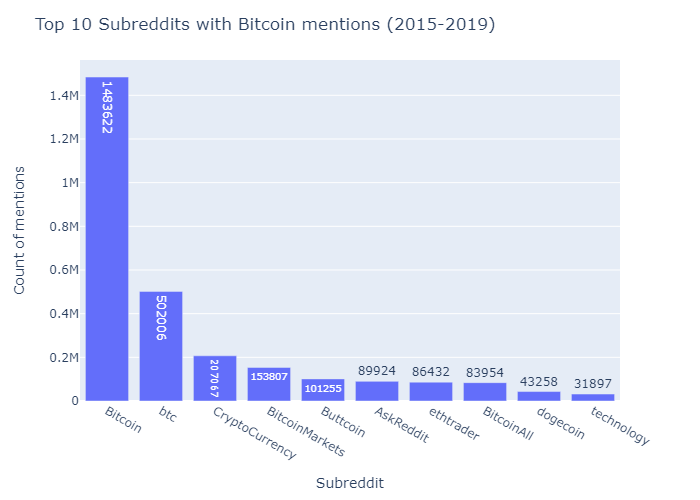

In [18]:
top10 = reddit.subreddit.value_counts().to_frame('Count of mentions')[:10].reset_index()
top10_l = top10['index'].to_list()
fig = px.bar(top10, x='index', y='Count of mentions', text= 'Count of mentions')


fig.update_layout(
    showlegend=False,
    title = "Top 10 Subreddits with Bitcoin mentions (2015-2019)",
    xaxis_title = "Subreddit",
    yaxis_title = "Count of mentions"
)


figindex += 1
figshow(figindex,fig)

The 10 subreddits above comprise the majority of Bitcoin mentions in the dataset.

In spite of the non-serious nature of subreddits (the forum names say it all), during the analysed period it consisted of one of the main cryptocurrency niches. Therefore, no information will be discarded for the sake of getting the most of Reddit as a proxy for BTC market sentiment.

In [19]:
# Per VADER's documentation:

# positive sentiment : (compound score >= 0.05) 
# neutral sentiment : (compound score > -0.05) and (compound score < 0.05) 
# negative sentiment : (compound score <= -0.05)

condic = [reddit['Sentiment'] >= 0.05,
              (reddit['Sentiment'] > -0.05) & (reddit['Sentiment'] < 0.05),
              reddit['Sentiment'] <= -0.05]

choices = ['positive','neutral','negative']        

reddit['Polarity'] = np.select(condic, choices)
reddit.head()

,subreddit,score,Created Date,Comment,Sentiment,score_norm,Sentiment_weighted,Day,Polarity
0,business,1.0,2009-05-08 13:54:29,"Interesting, it uses IRC as a high level proto...",0.4019,0.053031,0.021313,2009-05-08,positive
2,business,2.0,2009-05-08 14:29:56,No - the richest person will be the one with t...,0.5267,0.053064,0.027949,2009-05-08,positive
4,business,-3.0,2009-05-08 16:35:36,&gt;a public list of all the previous transact...,-0.0772,0.052901,-0.004084,2009-05-08,negative
6,business,2.0,2009-05-08 19:35:24,"No, that's not how bitcoin works, check out th...",-0.2960,0.053064,-0.015707,2009-05-08,negative
8,business,0.0,2009-07-18 21:38:06,It's weird how Ron Paul gets money so incredib...,0.4968,0.052999,0.026330,2009-07-18,positive


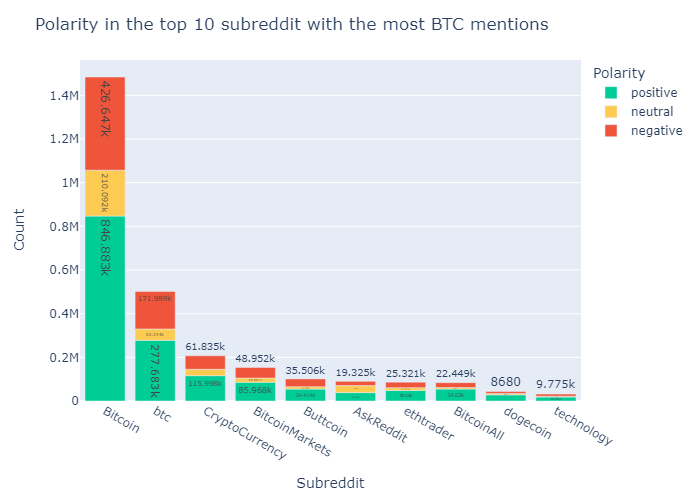

In [20]:
subredd_polar = reddit.query('subreddit.isin(@top10_l)').groupby('subreddit')['Polarity'].value_counts().to_frame('count').reset_index()
fig = px.bar(subredd_polar, x='subreddit', y='count', color='Polarity', color_discrete_map= {'positive':'#00CC96','neutral':'#FECB52', 'negative':'#EF553B'},text_auto=True)
fig.update_xaxes(categoryorder='array',categoryarray=top10_l)
fig.update_layout(
    title='Polarity in the top 10 subreddit with the most BTC mentions',
    xaxis_title = 'Subreddit',
    yaxis_title = 'Count'
)

figindex += 1
figshow(figindex,fig)

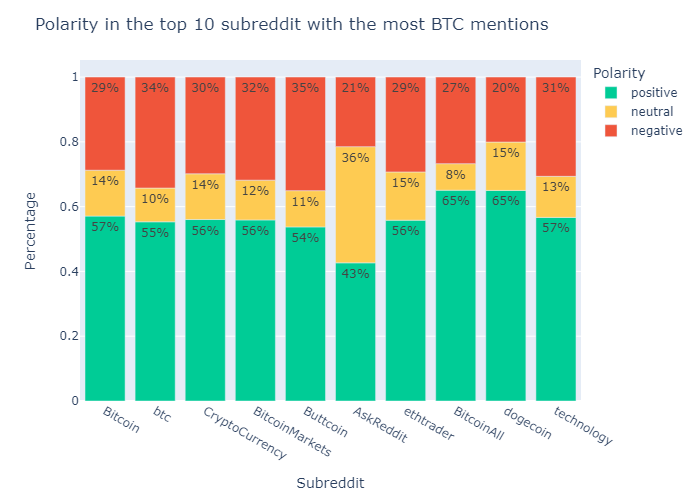

In [21]:
subredd_polar = reddit.query('subreddit.isin(@top10_l)').groupby('subreddit')['Polarity'].value_counts(normalize=True).to_frame('count').reset_index()
fig = px.bar(subredd_polar, x='subreddit', y='count', text=subredd_polar['count'].apply(lambda x: '{:.0%}'.format(x)), color='Polarity', color_discrete_map= {'positive':'#00CC96','neutral':'#FECB52', 'negative':'#EF553B'})
fig.update_xaxes(categoryorder='array',categoryarray=top10_l)
fig.update_layout(
    title='Polarity in the top 10 subreddit with the most BTC mentions',
    xaxis_title = 'Subreddit',
    yaxis_title = 'Percentage'
)
figindex += 1
figshow(figindex,fig)

It is clear that people who talked about Bitcoin online between 2015-2019 had a positive bias towards it.

Noticeably, the last 2 of the top 10 forums had the highest proportion of positive BTC comments, which is due to the fact that those 2 forums are frequented by sex workers who get paid in the currency and are not interested in its speculative nature.

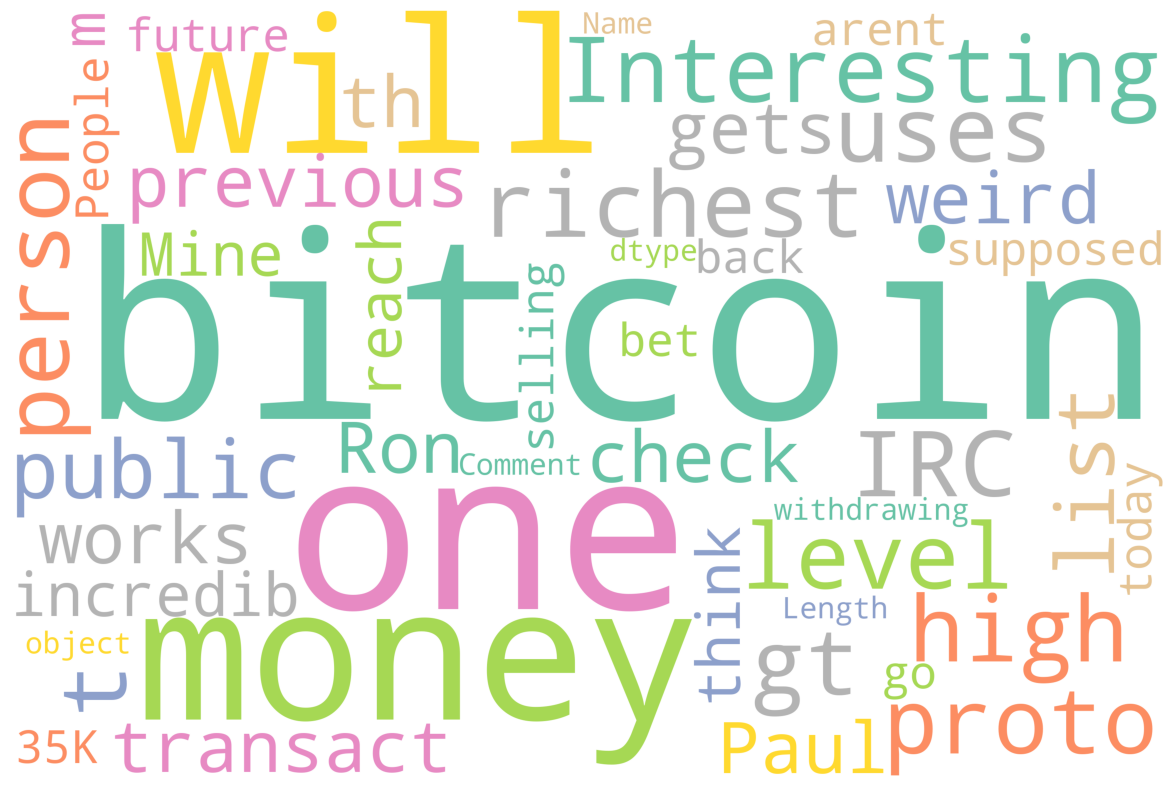

In [75]:
# In order to get words most frequently associated with BTC mentions:
def plot_cloud(wordcloud,title=''):
    # Set figure size
    plt.figure(figsize=(25, 10))
    # Display image
    plt.title(title)
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");



wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='white', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(str(reddit.Comment))
# Plot
plot_cloud(wordcloud)


Above we have a wordcloud of the words most frequently associated with Bitcoin mentions.

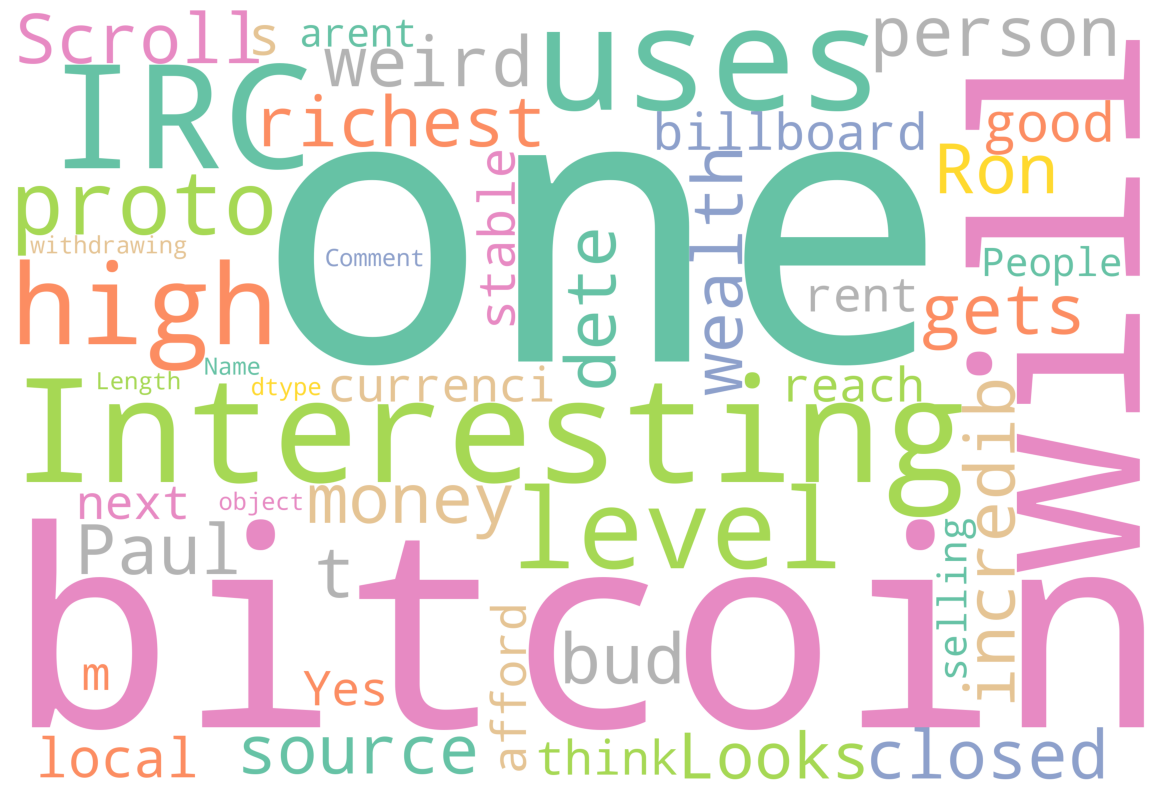

In [77]:
# In order to get words most frequently associated with BTC mentions:
def plot_cloud(wordcloud,title=''):
    # Set figure size
    plt.figure(figsize=(25, 10))
    # Display image
    plt.title(title)
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");



wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='white', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(str(reddit.query('Polarity=="positive"').Comment))
# Plot
plot_cloud(wordcloud)

Depicted above are the words most frequently associated with positive Bitcoin mentions.

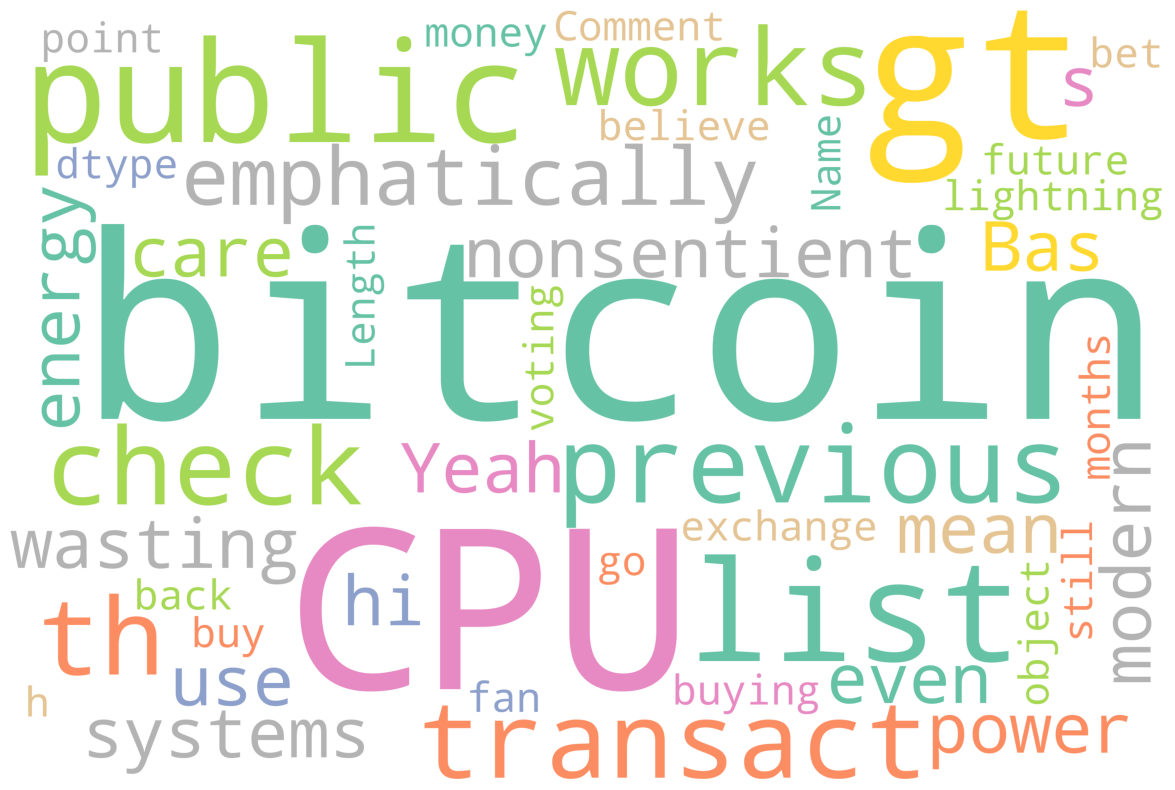

In [78]:
# In order to get words most frequently associated with BTC mentions:
def plot_cloud(wordcloud,title=''):
    # Set figure size
    plt.figure(figsize=(25, 10))
    # Display image
    plt.title(title)
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");



wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='white', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(str(reddit.query('Polarity=="negative"').Comment))
# Plot
plot_cloud(wordcloud)

Above are the most frequent words in negative mentions to the cryptocurrency.


Daily aggregations:

In [42]:
#Daily aggregations:

reddit_ = reddit.groupby('Day')['Sentiment_weighted'].agg({'count', 'sum', 'mean', 'median'})

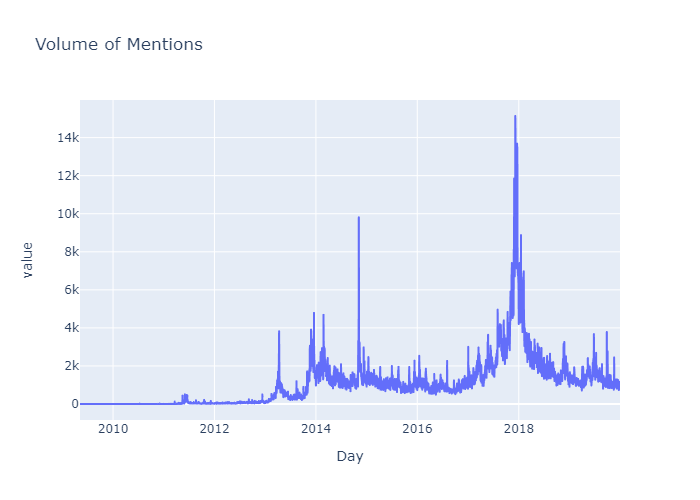

In [43]:
fig = px.line(reddit_['count'], title='Volume of Mentions')
fig.update_layout(showlegend=False)


figindex += 1
figshow(figindex,fig)

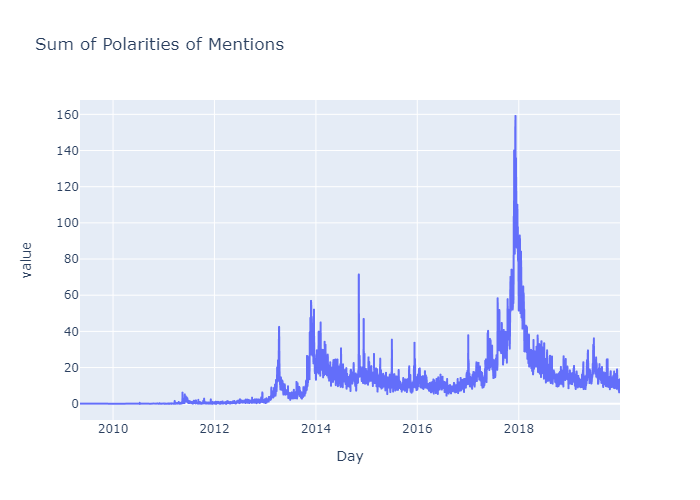

In [44]:
fig = px.line(reddit_['sum'], title='Sum of Polarities of Mentions')
fig.update_layout(showlegend=False)

figindex += 1
figshow(figindex,fig)

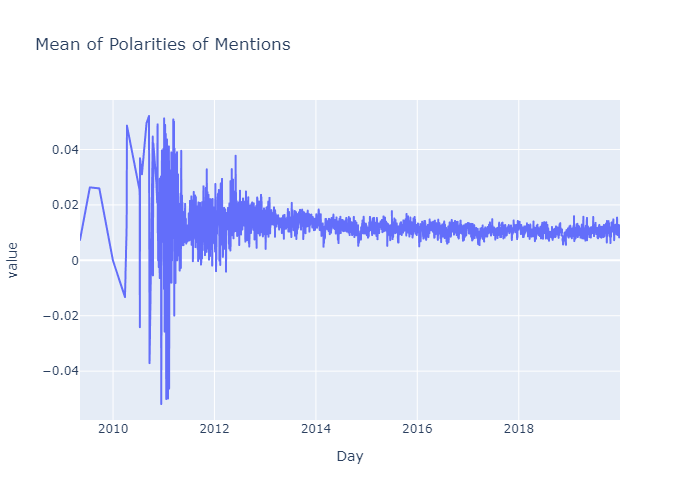

In [45]:
fig = px.line(reddit_['mean'], title='Mean of Polarities of Mentions')
fig.update_layout(showlegend=False)

figindex += 1
figshow(figindex,fig)

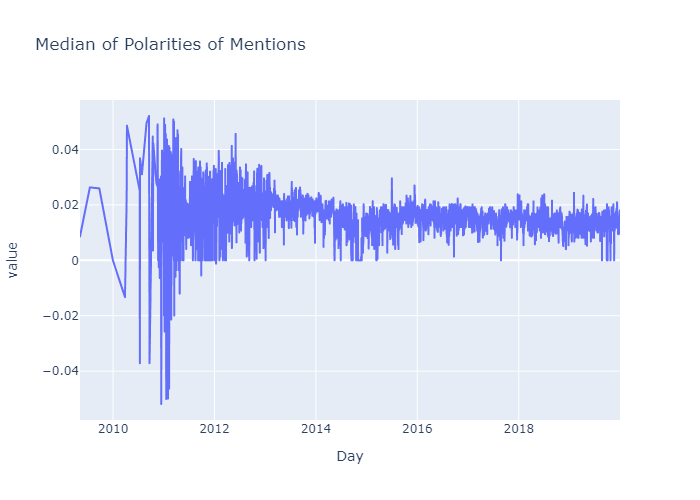

In [46]:
fig = px.line(reddit_['median'], title='Median of Polarities of Mentions')
fig.update_layout(showlegend=False)

figindex += 1
figshow(figindex,fig)

As the sum of mentions is considerably influenced by volume, we should consider the following as potential features:

* Daily Weighted Mean of Sentiments

* Volume of Mentions

* Daily Sum of weighted Sentiments (which contains volume)

Considering both time series at once:

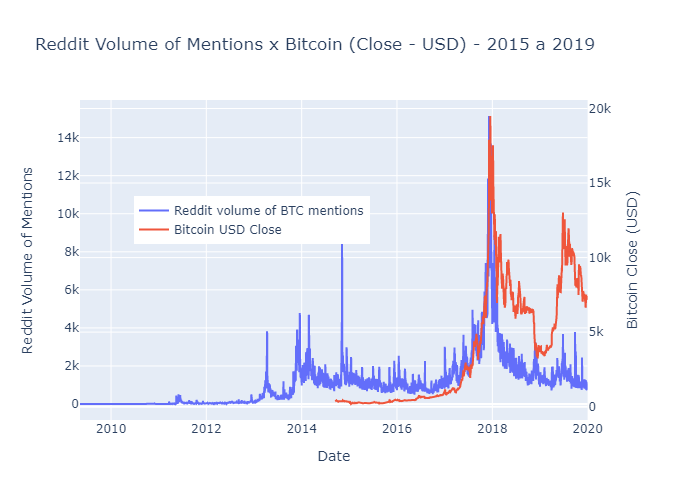

In [47]:
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(
    go.Scatter(x = reddit_.index,y = reddit_['count'], name="Reddit volume of BTC mentions"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x = btc.query('Date<="2020-01-01"').Date, y = btc.query('Date<="2020-01-01"')['Close'], name = "Bitcoin USD Close"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Reddit Volume of Mentions x Bitcoin (Close - USD) - 2015 a 2019",
    legend = dict(x=0.1, y=0.7)
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="Reddit Volume of Mentions", secondary_y=False)
fig.update_yaxes(title_text="Bitcoin Close (USD)", secondary_y=True)

figindex += 1
figshow(figindex,fig)

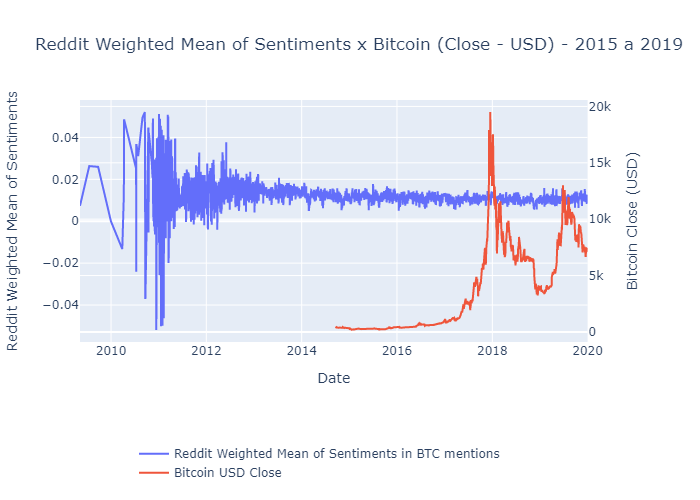

In [83]:
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(
    go.Scatter(x = reddit_.index,y = reddit_['mean'], name="Reddit Weighted Mean of Sentiments in BTC mentions"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x = btc.query('Date<="2020-01-01"').Date, y = btc.query('Date<="2020-01-01"')['Close'], name = "Bitcoin USD Close"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Reddit Weighted Mean of Sentiments x Bitcoin (Close - USD) - 2015 a 2019",
    legend = dict(x=0.1, y=-0.6)
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="Reddit Weighted Mean of Sentiments", secondary_y=False)
fig.update_yaxes(title_text="Bitcoin Close (USD)", secondary_y=True)

figindex += 1
figshow(figindex,fig)

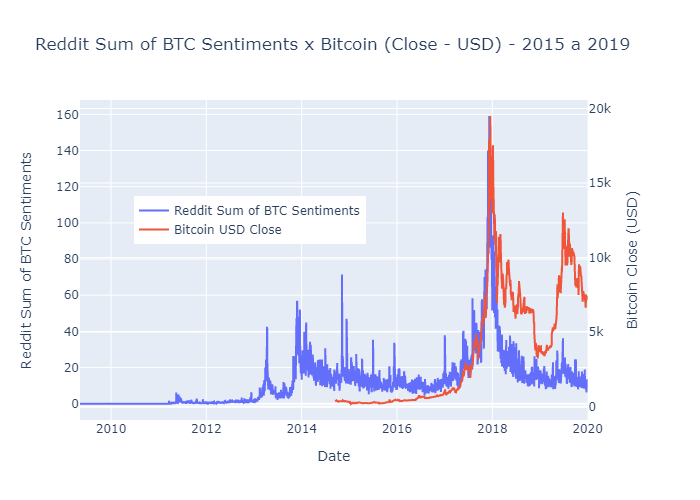

In [49]:
fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(
    go.Scatter(x = reddit_.index,y = reddit_['sum'], name="Reddit Sum of BTC Sentiments"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x = btc.query('Date<="2020-01-01"').Date, y = btc.query('Date<="2020-01-01"')['Close'], name = "Bitcoin USD Close"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Reddit Sum of BTC Sentiments x Bitcoin (Close - USD) - 2015 a 2019",
    legend = dict(x=0.1, y=0.7)
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="Reddit Sum of BTC Sentiments", secondary_y=False)
fig.update_yaxes(title_text="Bitcoin Close (USD)", secondary_y=True)

figindex += 1
figshow(figindex,fig)

From the visualizations above, it seems like the daily sum of sentiments follows the BTC close trends more consistently, sometimes even anticipating drastic movements. We then join the daily datasets.

In [50]:
reddit_

,mean,median,sum,count
Day,,,,
2009-05-08,0.007368,0.008615,0.029471,4
2009-07-18,0.026330,0.026330,0.026330,1
2009-09-24,0.025969,0.025969,0.051939,2
2009-12-31,0.000000,0.000000,0.000000,1
2010-03-28,-0.013266,-0.013266,-0.013266,1
...,...,...,...,...
2019-12-27,0.009766,0.010745,8.730920,894
2019-12-28,0.010650,0.013680,8.200507,770
2019-12-29,0.010829,0.013223,9.670220,893


In [51]:
df = btc.set_index('Date').merge(reddit_.add_suffix('_sent').reset_index(), left_on='Date', right_on='Day', how='inner')
df = df.sort_values('Day').set_index('Day')
df.head()

,Open,High,Low,Close,Adj Close,Volume,Pct_chg,Log_Return,mean_sent,median_sent,sum_sent,count_sent
Day,,,,,,,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,NaN,NaN,0.010751,0.008117,12.019563,1118
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,-0.071926,-0.074643,0.010097,0.000000,13.953736,1382
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,-0.069843,-0.072402,0.009086,0.000000,13.401700,1475
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,0.035735,0.035111,0.011065,0.004097,11.087224,1002
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,-0.024659,-0.024968,0.012167,0.011994,11.424924,939


In [52]:
df.shape

(1932, 12)

Which yields us a dataset with 1826 observations ranging from 2015 to 2019, already enriched with the daily reddit sentiment descriptive statistics.

---
### Feature Engineering - Technical Analysis Indicators

Using pandas-TA built-in convenience, we create many different technical indicators at once.

In [53]:
# The suggested lookback periods
lookbacks = [5,10,21,50]

# Defining inputs:
inputs = {
    'open': df['Open'],
    'high':df['High'],
    'low': df['Low'],
    'close':df['Close'],
    'volume':df['Volume'],
}

Creating Technical indicators

In [54]:
# For dfereum:
for func in ['EMA', 'ATR', 'STOCH', 'MACD', 'CCI', 'AD', 'BBANDS', 'MOM','RSI']:
    for l in lookbacks:
        col_name = f'{func}_{l}'
        
        try: #will only vary timeperiods if time period is present as a parameter
            df[col_name] = eval(f'{func}(inputs, timeperiod={l})')
            
        except: #when time window is not present as a parameter & or there is more than 1 output
            # print(col_name)
            if func == "STOCH":    
                col_name = f'{func}'
                df[col_name+'_slowk'],df[col_name+'_slowd'] = eval(f'{func}(inputs)')
            elif func =="MACD":
                col_name = f'{func}'
                df[col_name], df[col_name+ '_signal'], df[col_name+ '_hist'] = eval(f'{func}(inputs)')
            elif func =="BBANDS":
                df[col_name+'_upperband'], df[col_name+ '_middleband'], df[col_name+ '_lowerband '] = eval(f'{func}(inputs, timeperiod={l})')
            else:
                print(col_name+' deu ruim')
                pass

# Adding drift-independent volatility (Yang & Zhang)

for l in lookbacks:
    df[f'di_vol_{l}'] = get_hvol_yz(df,lookback=l)

In [55]:
# We also backfill columns to avoid NaNs
df = df.bfill(axis=0)

We then define the target variable as the pct_change direction:

In [56]:
df['target'] = np.where(df['Pct_chg']>0, 1, 0)

In [57]:
classes = df['target'].value_counts()
classes

1    1051
0     881
Name: target, dtype: int64

As we have class imbalance, we assign appropriate weights (inversely proportional to the number of observations):

In [58]:
class_weights = cwts(df)
class_weights

{0: 1.0964812712826333, 1: 0.9191246431969553}

Which yields equal weight per class:

In [59]:
round(class_weights[0] * classes[0]), round(class_weights[1] * classes[1])

(966, 966)

In [60]:
# Dropping unnecessary columns
df = df.drop(['Open','High','Low', 'Close','Adj Close','Volume','Log_Return'], axis=1)
print(df.shape)
df.head()

(1932, 51)


,Pct_chg,mean_sent,median_sent,sum_sent,count_sent,EMA_5,EMA_10,EMA_21,EMA_50,ATR_5,...,MOM_50,RSI_5,RSI_10,RSI_21,RSI_50,di_vol_5,di_vol_10,di_vol_21,di_vol_50,target
Day,,,,,,,,,,,,,,,,,,,,,
2014-09-17,-0.071926,0.010751,0.008117,12.019563,1118,416.859003,416.144199,387.352142,372.76684,29.995392,...,-108.044006,19.363753,31.929726,32.267866,39.540104,81.334074,64.675806,76.361885,59.861465,0
2014-09-18,-0.071926,0.010097,0.000000,13.953736,1382,416.859003,416.144199,387.352142,372.76684,29.995392,...,-108.044006,19.363753,31.929726,32.267866,39.540104,81.334074,64.675806,76.361885,59.861465,0
2014-09-19,-0.069843,0.009086,0.000000,13.401700,1475,416.859003,416.144199,387.352142,372.76684,29.995392,...,-108.044006,19.363753,31.929726,32.267866,39.540104,81.334074,64.675806,76.361885,59.861465,0
2014-09-20,0.035735,0.011065,0.004097,11.087224,1002,416.859003,416.144199,387.352142,372.76684,29.995392,...,-108.044006,19.363753,31.929726,32.267866,39.540104,81.334074,64.675806,76.361885,59.861465,1
2014-09-21,-0.024659,0.012167,0.011994,11.424924,939,416.859003,416.144199,387.352142,372.76684,29.995392,...,-108.044006,19.363753,31.929726,32.267866,39.540104,81.334074,64.675806,76.361885,59.861465,0


---
### Correlation Matrix

In [61]:
# Converting everything to float:
df= df.astype('float')

Everything except the target (categorical x quantitative does not work) variable.

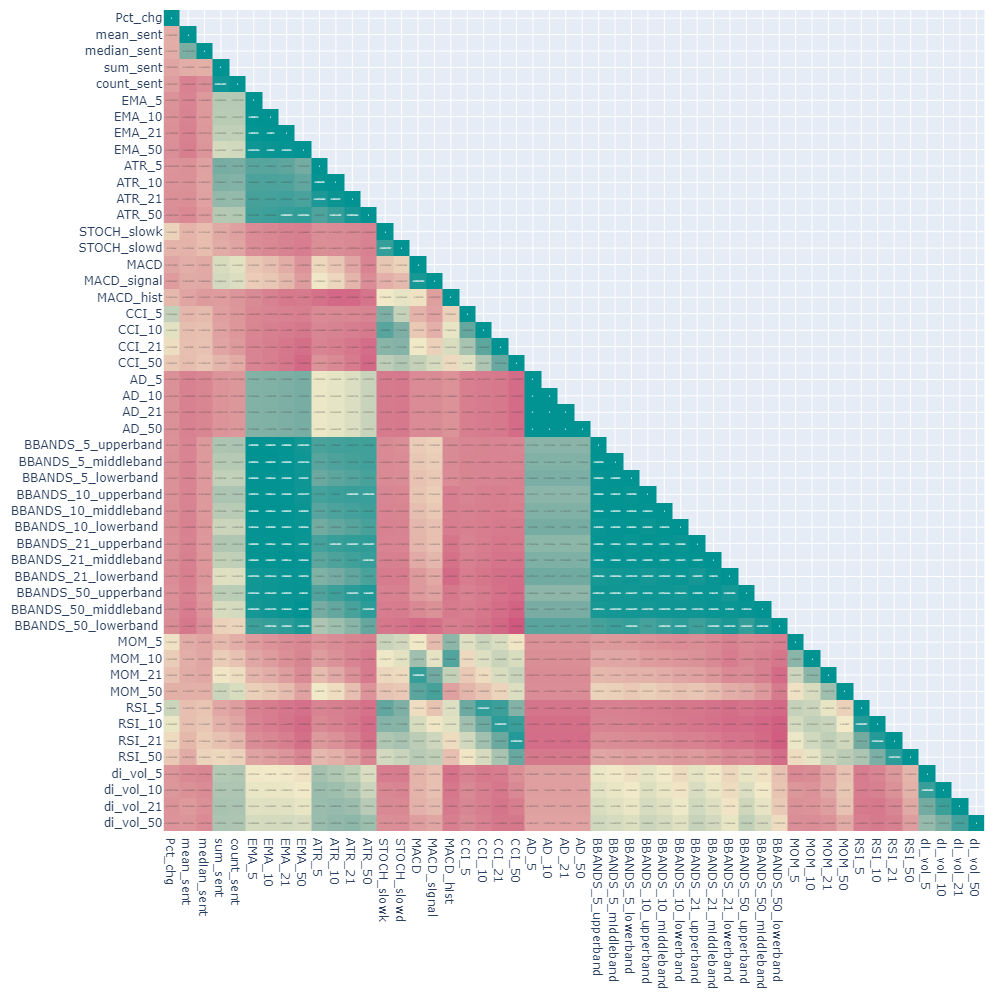

In [62]:
mask = np.triu(np.ones_like(df.iloc[:,:-1].corr(), dtype=bool))

fig = px.imshow(df.iloc[:,:-1].corr().where(np.tril(np.ones(df.iloc[:,:-1].corr().shape)).astype(bool)),color_continuous_scale='tealrose_r', text_auto=True)
fig.update_layout(
    height = 1000,
    width = 1000,
    margin=dict(l=10, r=10, t=10, b=10), 
    coloraxis_showscale=False)
figindex += 1
figshow(figindex,fig)

As it is, there are too many features to check visually. We will come back to this later.

For now, let's check the correlation matrix with the Reddit features:

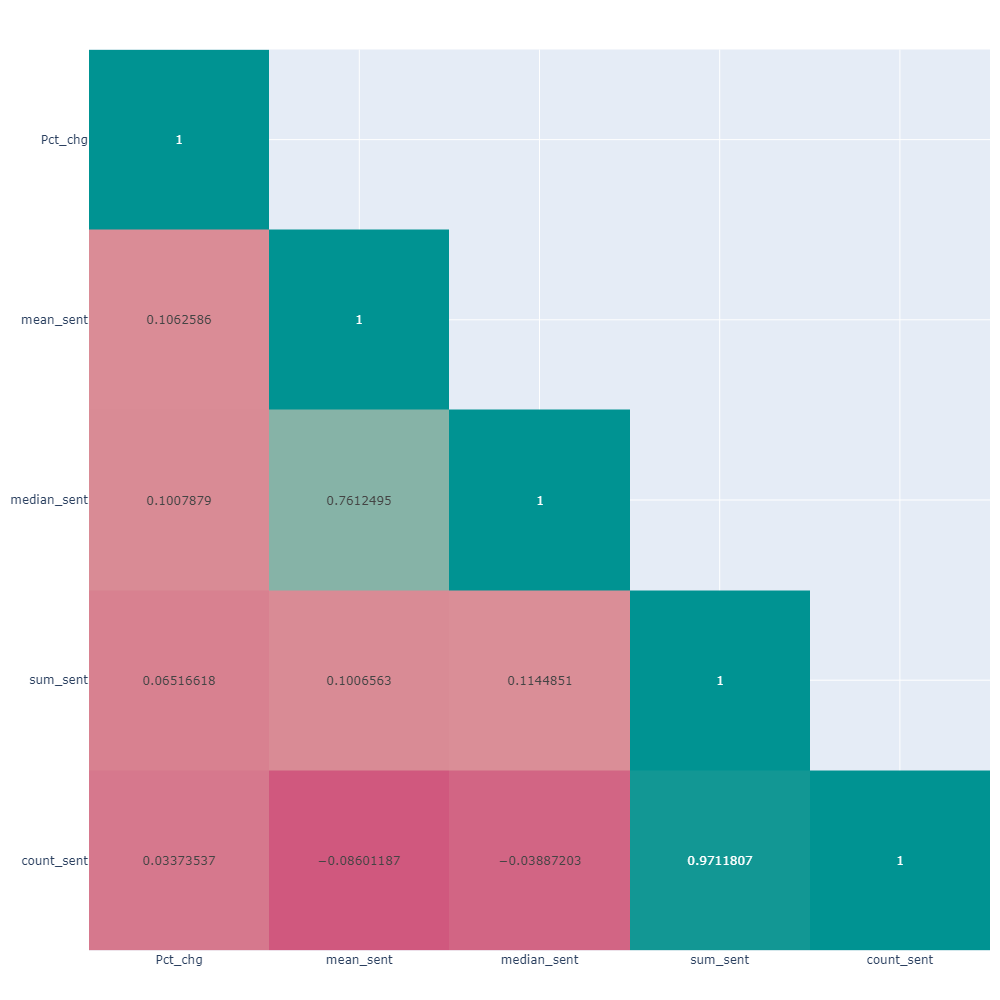

In [63]:
mask = np.triu(np.ones_like(df.iloc[:,:5].corr(), dtype=bool))

fig = px.imshow(df.iloc[:,:5].corr().where(np.tril(np.ones(df.iloc[:,:5].corr().shape)).astype(bool)),color_continuous_scale='tealrose_r', text_auto=True)
fig.update_layout(
    height = 1000,
    width = 1000,
    margin=dict(l=10, r=10, t=10, b=10), 
    coloraxis_showscale=False)
figindex += 1
figshow(figindex,fig)

Despite what the previous plots showed, it seems like the mean and median are more correlated to the Pct_chg of BTC Close.

What are the top 10 features with highest correlation?

In [64]:
top_corr = df.corr()['Pct_chg'][df.corr()['Pct_chg'].abs().sort_values(ascending=False)[2:12].index].to_frame()
top_corr

,Pct_chg
CCI_5,0.521848
RSI_5,0.494987
CCI_10,0.416146
RSI_10,0.391685
MOM_5,0.326154
CCI_21,0.312690
RSI_21,0.301285
STOCH_slowk,0.262494
MOM_10,0.241539
CCI_50,0.224362


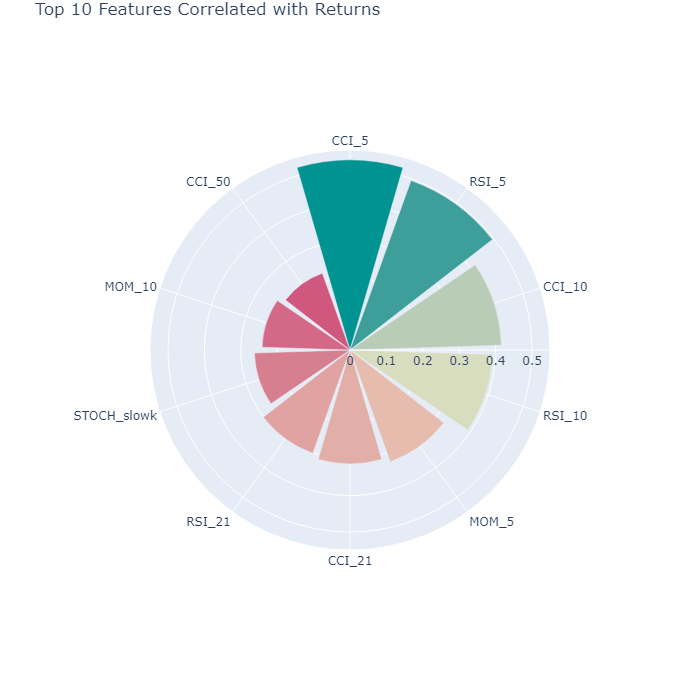

In [65]:
fig = px.bar_polar(top_corr, r = top_corr['Pct_chg'], theta=top_corr.index, color = top_corr['Pct_chg'], title ='Top 10 Features Correlated with Returns',color_continuous_scale='tealrose_r') 
fig.update_layout(
    height = 700,
    width = 700,
    margin=dict(l=150, r=150, t=30, b=30), 
    coloraxis_showscale=False)
figindex += 1
figshow(figindex,fig)

It is clear that momentum indicators, such as MOM and RSI, are more correlated with the BTC daily returns.

---
### Feature Selection with Boruta

As an alternative to the DTR feature selection suggested, the Boruta tool is used (with a Random Forest Classifier).

In [66]:
df_ = df.drop(['Pct_chg','median_sent'], axis=1)

# removing median because we'll be using mean (per  correlation)
X, y = df_.drop(['target'], axis=1).values,df_['target'].values

In [67]:
# Define random forest classifier with the weighted classes:
forest = RandomForestClassifier(n_jobs=-1, class_weight=class_weights, max_depth=5)
forest.fit(X, y)

RandomForestClassifier(class_weight={0: 1.0964812712826333,
                                     1: 0.9191246431969553},
                       max_depth=5, n_jobs=-1)

In [69]:
# define Boruta feature selection method
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=1, perc=80)

# find all relevant features
feat_selector.fit(X, y)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	48
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	48
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	48
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	48
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	48
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	48
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	48
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	15
Tentative: 	5
Rejected: 	28
Iteration: 	9 / 100
Confirmed: 	15
Tentative: 	5
Rejected: 	28
Iteration: 	10 / 100
Confirmed: 	15
Tentative: 	5
Rejected: 	28
Iteration: 	11 / 100
Confirmed: 	15
Tentative: 	5
Rejected: 	28
Iteration: 	12 / 100
Confirmed: 	15
Tentative: 	2
Rejected: 	31
Iteration: 	13 / 100
Confirmed: 	15
Tentative: 	2
Rejected: 	31
Iteration: 	14 / 100
Confirmed: 	15
Tentative: 	2
Rejected: 	31
Iteration: 	15 / 100
Confirmed: 	15
Tentative: 	2
Rejected: 	31
Iteration: 	16 / 100
Confirmed: 	15
Tentative: 	1
Reject

BorutaPy(estimator=RandomForestClassifier(class_weight={0: 1.0964812712826333,
                                                        1: 0.9191246431969553},
                                          max_depth=5, n_estimators=113,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x1AB4D334540),
         n_estimators='auto', perc=80,
         random_state=RandomState(MT19937) at 0x1AB4D334540, verbose=2)

In [70]:
feature_ranks = list(zip(df_.columns, 
                         feat_selector.ranking_, 
                         feat_selector.support_,
                         feat_selector.support_weak_))

# iterate through and print out the results
boruta = defaultdict(list)
for feat in feature_ranks:
    boruta['Feature'].append(feat[0])
    boruta['Rank'].append(feat[1])
    boruta['Keep'].append(feat[2])
    

boruta = pd.DataFrame(boruta).set_index('Feature')

In [71]:
boruta.sort_values('Rank', ascending=True)

,Rank,Keep
Feature,,
MOM_5,1,True
CCI_10,1,True
MACD,1,True
STOCH_slowd,1,True
STOCH_slowk,1,True
CCI_21,1,True
CCI_50,1,True
MACD_hist,1,True
CCI_5,1,True


---
### Selected Features

The drift independent volatility did not make the cut, we proceed to use only the features ranked #1.

In [72]:
selected = list(boruta.query('Rank==1').index)
boruta.query('Rank==1')

,Rank,Keep
Feature,,
STOCH_slowk,1,True
STOCH_slowd,1,True
MACD,1,True
MACD_hist,1,True
CCI_5,1,True
CCI_10,1,True
CCI_21,1,True
CCI_50,1,True
MOM_5,1,True


Checking the correlation matrix for the selected features:

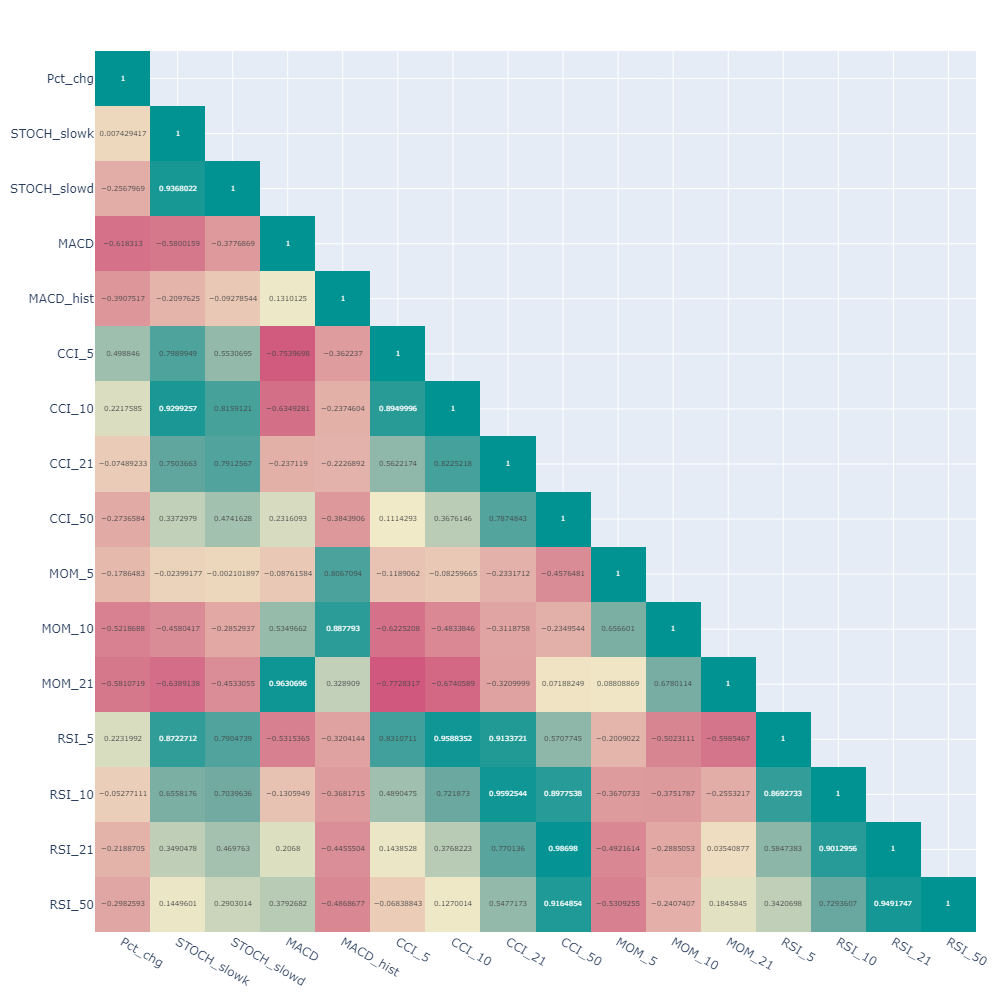

In [73]:
corr_final = df[['Pct_chg'] + selected].corr()
mask = np.triu(np.ones_like(corr_final.iloc[:,:5].corr(), dtype=bool))

fig = px.imshow(corr_final.corr().where(np.tril(np.ones(corr_final.corr().shape)).astype(bool)),color_continuous_scale='tealrose_r', text_auto=True)
fig.update_layout(
    height = 1000,
    width = 1000,
    margin=dict(l=10, r=10, t=10, b=10), 
    coloraxis_showscale=False)

figindex += 1
figshow(figindex,fig)

Therefore the Boruta selected features also bear high correlation to the Bitcoin returns.

Considering the objective is to predict up/down movements, the target variable is set and the Pct change of returns is discarded.

In [74]:
# Exporting to use in the Deep Learning modeling
df[['target'] + selected].to_csv('datasets/final_db.csv')